# Оценка результатов А/B-тестирования   

В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.  

**Цель**  

Провести оценку результатов A/B-теста. 

**Задачи**

Оценить корректность проведения теста и проанализировать его результаты:   

* проверить, нет ли пересечений с конкурирующим тестом и нет ли пользователей, участвующих в двух группах теста одновременно;
* проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.

**Описание данных**

`/datasets/ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год;

* `name` — название маркетингового события;
* `regions` — регионы, в которых будет проводиться рекламная кампания;
* `start_dt` — дата начала кампании;
* `finish_dt` — дата завершения кампании.

`/datasets/final_ab_new_users.csv` — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;

* `user_id` — идентификатор пользователя;
* `first_date` — дата регистрации;
* `region` — регион пользователя;
* `device` — устройство, с которого происходила регистрация.

`/datasets/final_ab_events.csv` — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;

* `user_id` — идентификатор пользователя;
* `event_dt` — дата и время события;
* `event_name` — тип события;
* `details` — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

`/datasets/final_ab_participants.csv` — таблица участников тестов.

* `user_id` — идентификатор пользователя;
* `ab_test` — название теста;
* `group` — группа пользователя.


**Оглавление**

1. [Изучение общей информации](#start)  
    * [Календарь маркетинговых событий на 2020 год](#calendar)
    * [Пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года](#user)
    * [События новых пользователей в период с 7 декабря 2020 по 4 января 2021 года](#events)
    * [Таблица участников тестов](#tests)
2. [Предобработка данных](#pre)  
3. [Оценка корректности проведения теста](#corr)
    * [Соответствие ТЗ по пользователям](#corr_users)
    * [Соответствие ТЗ по датам](#corr_date)
    * [Соответствие ТЗ по событиям](#corr_events)
4. [Исследовательский анализ данных](#research)
    * [Анализ событий](#analysis_events)
    * [Воронка событий](#funnel)
5. [Оценка результатов A/B-тестирования](#stats)
6. [Общий вывод и рекомендации](#rec)

<a id="start"></a>
## Изучение общей информации  

Загружаем данные о маркетинговых событиях на 2020 год, о пользователях, зарегистрировавшихся в интернет-магазине в период с 7 по 21 декабря 2020 года, о событиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года и о участниках тестов из CSV-файлов в переменные.   


In [1]:
import pandas as pd
import datetime as dt
from datetime import timedelta
import numpy as np
import scipy.stats as stats
import plotly.express as px
from itertools import cycle
from plotly import graph_objects as go
import math as mth

# Скрываем ошибки
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)

In [2]:
# загружаем библиотеку, настроим вывод графиков в формате "png" по деффолту для отображения на GitHub 
import plotly.io as pio 
pio.renderers.default = "png" 
svg_renderer = pio.renderers["png"] 
svg_renderer.scale = 1.4

In [3]:
path = '/datasets/'
calendar, users, events, participants = (pd.read_csv(path + 'ab_project_marketing_events.csv'),
                                             pd.read_csv(path + 'final_ab_new_users.csv'),
                                             pd.read_csv(path + 'final_ab_events.csv'),
                                             pd.read_csv(path + 'final_ab_participants.csv'))

In [4]:
# напишем функцию для полного описания данных
def total_describe(data):
    data_head = data.head(14)
    data_info = data.info()
    data_isna = pd.DataFrame(data.isna().sum())
    data_isna.columns = ['count_miss']
    display(data_info)
    print('Первые 14 строк таблицы:')
    display(data_head)
    print('Информация о пропусках в данных:')
    display(data_isna)
    print('Краткое описание для всех столбцов')
    display(data.describe(include='all'));

<a id="calendar"></a>

### Календарь маркетинговых событий на 2020 год

In [5]:
total_describe(calendar)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

Первые 14 строк таблицы:


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Информация о пропусках в данных:


,count_miss
name,0
regions,0
start_dt,0
finish_dt,0


Краткое описание для всех столбцов


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


**Вывод:**  
Файл `ab_project_marketing_events.csv` содержит информацию о  маркетинговых событиях на 2020 год.  
Всего в датасете 14 записей и 4 столбца.

* Столбцы `start_dt` и `finish_dt` имеют некорректный тип данных
* Пропуски отсутствуют 
* Наименования столбцов записаны корректно
* Дубликаты отсутствуют

<a id="user"></a>

### Пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года

In [6]:
total_describe(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

Первые 14 строк таблицы:


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android


Информация о пропусках в данных:


,count_miss
user_id,0
first_date,0
region,0
device,0


Краткое описание для всех столбцов


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


**Вывод:**  
Файл `final_ab_new_users.csv` содержит информацию о всех пользователях, зарегистрировавшихся в интернет-магазине в период с 7 по 21 декабря 2020 года.  
Всего в датасете 61733 записи и 4 столбца.

* Столбец `first_date` имеет некорректный тип данных
* Пропуски отсутствуют 
* Наименования столбцов записаны корректно
* В файле находятся только уникальные пользователи (61733)
* Краткое описание показывает, что в данных 17 уникальных дат, хотя должно быть всего 15, поэтому стоит проверить данные.

<a id="events"></a>

### События новых пользователей в период с 7 декабря 2020 по 4 января 2021 года

In [7]:
total_describe(events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

Первые 14 строк таблицы:


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


Информация о пропусках в данных:


,count_miss
user_id,0
event_dt,0
event_name,0
details,377577


Краткое описание для всех столбцов


,user_id,event_dt,event_name,details
count,440317,440317,440317,62740.000000
unique,58703,267268,4,NaN
top,A3917F81482141F2,2020-12-23 02:37:24,login,NaN
freq,36,10,189552,NaN
mean,NaN,NaN,NaN,23.877631
std,NaN,NaN,NaN,72.180465
min,NaN,NaN,NaN,4.990000
25%,NaN,NaN,NaN,4.990000
50%,NaN,NaN,NaN,4.990000
75%,NaN,NaN,NaN,9.990000


**Вывод:**  
Файл `final_ab_events.csv` содержит информацию о событиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.   
Всего в датасете 440317 записей и 4 столбца.

* Столбец `event_dt` имеет некорректный тип данных
* В столбце `details` 377577 пропусков 
* Наименования столбцов записаны корректно

<a id="tests"></a>

### Таблица участников тестов

In [8]:
total_describe(participants)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

Первые 14 строк таблицы:


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
7,C46FE336D240A054,A,recommender_system_test
8,92CB588012C10D3D,A,recommender_system_test
9,057AB296296C7FC0,B,recommender_system_test


Информация о пропусках в данных:


,count_miss
user_id,0
group,0
ab_test,0


Краткое описание для всех столбцов


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


**Вывод:**  
Файл `final_ab_participants.csv` содержит информацию о участниках тестов.   
Всего в датасете 18268 записи и 3 столбца.

* Столбцы имеют корректные типы данных
* Пропуски отсутствуют
* Наименования столбцов записаны корректно
* Краткое описание показывает, что в данных 16666 уникальных пользователей, хотя должны быть все уникальные, поэтому стоит проверить данные на пересечения.
* Также в данных присутствуют 2 унинкальных названия а/b-теста, нам же нужен только один - recommender_system_test.

**Итог**

Необходимо:   

* Проверить строки-дубликаты
* Заполнить по возможности пропуски в `details`
* Изменить типы данных в столбцах `start_dt`, `finish_dt`, `first_date`, `event_dt`
* Также проверить данные на дубликаты и пересечения по ТЗ.

<a id="pre"></a>
## Предобработка данных 

* **Изменение типа данных**  

Заменим типы данных в столбцах `start_dt`, `finish_dt`, `first_date`, `event_dt`.

In [9]:
# изменяем типы данных
calendar['start_dt'] = pd.to_datetime(calendar['start_dt']).dt.date
calendar['finish_dt'] = pd.to_datetime(calendar['finish_dt']).dt.date
users['first_date'] = pd.to_datetime(users['first_date']).dt.date
events['event_time'] = pd.to_datetime(events['event_dt'])
events['event_dt'] = pd.to_datetime(events['event_dt']).dt.date

* **Обработка дубликатов**

Проверим присутствие строк-дубликатов в каждом датафрейме.

In [10]:
datasets = [calendar, users, events, participants]

# посчитаем количество строк-дубликатов
for data in datasets:
    print(f'Количество строк-дубликатов: {data.duplicated().sum()}')

Количество строк-дубликатов: 0
Количество строк-дубликатов: 0
Количество строк-дубликатов: 0
Количество строк-дубликатов: 0


Строки дубликаты отсутствуют.

* **Обработка пропусков**

В таблице событий в столбце `details` присутствуют пропуски. Поскольку `details` это дополнительные данные о событии, выведем для начала названия уникальных событий и разберем, что они могут означать. 

In [11]:
events.groupby('event_name').describe()

details                                                      
                count       mean        std   min   25%   50%   75%     max
event_name                                                                 
login             0.0        NaN        NaN   NaN   NaN   NaN   NaN     NaN
product_cart      0.0        NaN        NaN   NaN   NaN   NaN   NaN     NaN
product_page      0.0        NaN        NaN   NaN   NaN   NaN   NaN     NaN
purchase      62740.0  23.877631  72.180465  4.99  4.99  4.99  9.99  499.99

Всего в данных имеется 4 события. Можем предположить, что:
* `login` - вход
* `product_page` - страница товара
* `product_cart` - страница корзины с товаром
* `purchase` - покупка товара

Пропуски присутствуют у всех событий, кроме `purchase`, в которой хранится стоимость покупки в долларах. Поскольку по другим события нечего добавить и это является лишь доп информацией, то пропуски оставим без изменения.

**Вывод по разделу:**  

В результате предобработки данных:

* изменили типы данных в `start_dt`, `finish_dt`, `first_date` и `event_dt`
* Пропуски обнаружились во всех событиях, кроме покупки. Не стали ничего менять
* Строк-дубликатов не обнаружили

<a id="corr"></a>
##  Оценка корректности проведения теста

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

<a id="corr_users"></a>

### Соответствие ТЗ по пользователям

    
Для начала посмотрим, какие А/В-тесты присутствуют в наших данных и количество участников в каждой из групп.

In [12]:
participants.groupby(['ab_test']).agg({'user_id': 'count'})

,user_id
ab_test,
interface_eu_test,11567
recommender_system_test,6701


В данных присутствуют 2 теста, но нас интересует только один из них - `recommender_system_test`. В нем участвуют 6701 пользователей.     

Проверим, есть ли пересечения пользователей в тесте "recommender_system_test" между группами.

In [13]:
# проверим пользователей на пересечения в тесте "recommender_system_test" между группами
doubles_users = len(np.intersect1d(participants.query('ab_test == "recommender_system_test" and group == "A"')['user_id'], 
                                   participants.query('ab_test == "recommender_system_test" and group == "B"')['user_id']))

print('Количество пользователей, попавших одновременно в обе группы теста "recommender_system_test": {}'.format(doubles_users))

Количество пользователей, попавших одновременно в обе группы теста "recommender_system_test": 0


В нашем тесте пересечений между группами нет. Проверим теперь, есть ли пересечения пользователей между нашим и конкурирующим А/В-тестом.

In [14]:
# используем np.intersect1d, чтобы найти пересечения в двух массивах, 
# т.е. пользователей, попавших одновременно в обе группы
doubles_users = np.intersect1d(participants.query('ab_test == "interface_eu_test"')['user_id'], 
                               participants.query('ab_test == "recommender_system_test"')['user_id'])
print(
    'Количество пользователей, попавших одновременно в оба А/В-теста: {}\n'
    'Количество уникальных пользователей, принявших участие в тестах: {}\n'
    'Процент пользователей, попавших одновременно в оба А/В-теста: {:.2%}'.format(len(doubles_users),
                                                                          participants['user_id'].nunique(), 
                                                                          len(doubles_users)/participants['user_id'].nunique())
)

Количество пользователей, попавших одновременно в оба А/В-теста: 1602
Количество уникальных пользователей, принявших участие в тестах: 16666
Процент пользователей, попавших одновременно в оба А/В-теста: 9.61%


Почти 10% пользователей попало в оба А/В-теста, что составляет 1602 пользователя из 16666 уникальных.  
Поскольку контрольная группа А использует неизменненую версию, то мы можем их оставить для нашего теста, но пользователей тестовой группы В, которые попали в оба теста одновременно, удалим из наших данных.

In [15]:
# заранее сохраним копию датафреймя в переменную. 
old_participants = participants.copy()

# в переменную doubles_users_A сохраним пользователей контрольной группы А конкурирующего теста, 
# которые пересекались в обоих тестах 
doubles_users_A = participants.query('user_id in @doubles_users and ab_test == "interface_eu_test" and group == "A"')['user_id']

# сохраняем пользователей пользователей теста "recommender_system_test" без пересечений и из переменной doubles_users_A  
doubles_users_rs = participants.query(
    '(ab_test == "recommender_system_test" and user_id not in @doubles_users) or user_id in @doubles_users_A')['user_id']

# оставим пользователей из doubles_users_rs только нашего теста
participants = participants.query('ab_test == "recommender_system_test" and user_id in @doubles_users_rs')

# проверим еще раз пересечения между группами нашего теста
doubles_users_v2 = np.intersect1d(participants.query('ab_test == "recommender_system_test" and group == "A"')['user_id'], 
                                  participants.query('ab_test == "recommender_system_test" and group == "B"')['user_id'])
print(
    'Оставшиееся количество уникальных пользователей, принявших участие в тесте "recommender_system_test": {}\n'
    'Процент потери пользователей после очистки, участвовавших в нашем тесте: {:.2%}\n'
    'Количество пользователей, попавших одновременно в обе группы нашего теста: {}'.format(
        len(participants),
        1 - len(participants)/len(old_participants.query('ab_test == "recommender_system_test"')),
        len(doubles_users_v2))
)

Оставшиееся количество уникальных пользователей, принявших участие в тесте "recommender_system_test": 5918
Процент потери пользователей после очистки, участвовавших в нашем тесте: 11.68%
Количество пользователей, попавших одновременно в обе группы нашего теста: 0


Процент потери пользователей после очистки, участвовавших в нашем тесте, составил 11.68%. Так у нас осталось в данных 5918 пользователей. Пересечений между группами не обнаружено, значит данные составлены корректно.     
Посмотрим, как распределились пользователи по группам и в каком соотношении.

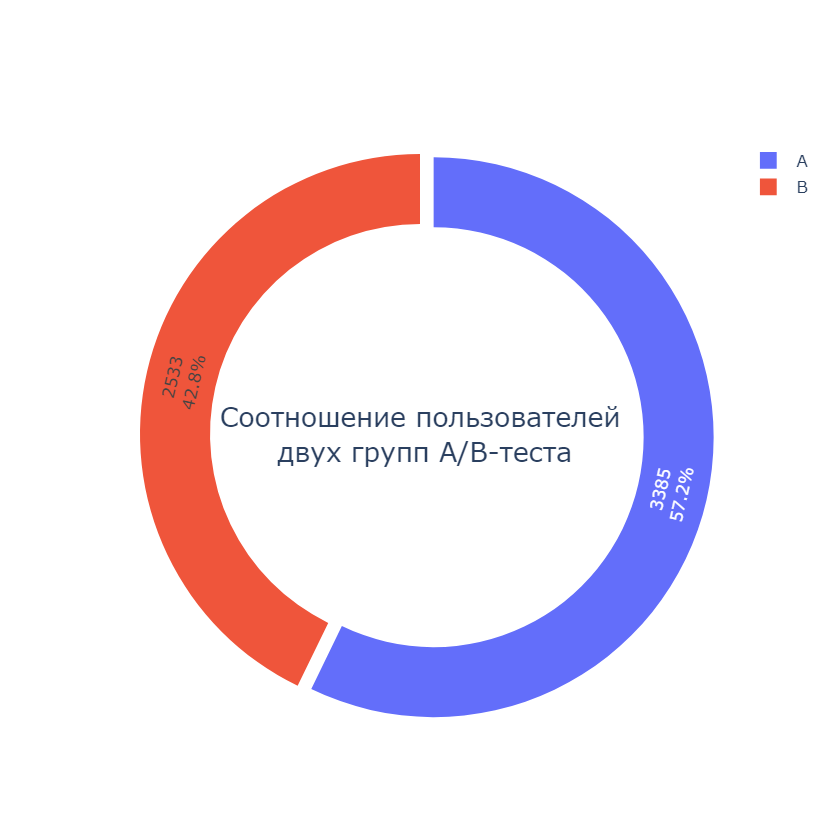

In [16]:
# сгрруппируем данные и посчитаем коичество пользователей в каждой группе
a_b = participants.groupby(['group']).agg({'user_id': 'nunique'}).reset_index()

# выведем круговую диаграмму
fig = go.Figure(data=[go.Pie(labels=['А', 'В'], 
                             values=a_b['user_id'],
                             pull=[0.05, 0],
                             hole=0.75)])
fig.update_layout(width=600,
                  height=600,
                  annotations=[dict(text='Соотношение пользователей<br> двух групп А/В-теста', 
                                   x=0.5, 
                                   y=0.5, 
                                   font_size=19, 
                                   showarrow=False)])
fig.update_traces(textinfo='percent + value')
fig.show()

Судя по диаграмме, в тестовой группе В находятся 2533 пользователя, что составляет около 43% от всех пользователей теста, и  3385 относятся к контрольной группе А, что составляет 57% от всех пользователей теста. Группы распределены почти равномерно.   
Проверим долю участников теста из Европы относительно всех новых пользователей из Европы.

In [17]:
# посчитаем количество участников теста из Европы
participants_eu = participants["user_id"]
participants_EU = len(users.query('user_id in @participants_eu and region == "EU"'))

# посчитаем количество новых пользователей из Европы
users_EU = len(users.query('region == "EU"'))

# посчитаем долю
print('Количество всего участников теста: {}\n'
      'Количество участников теста из Европы: {}\n'
      'Количество новых пользователей из Европы: {}\n'
      'Процент новых пользователей из региона EU, участвующих в А/В-тесте: {:.2%}'.format(participants['user_id'].nunique(),
                                                                                          participants_EU,
                                                                                          users_EU,
                                                                                          participants_EU/users_EU))

Количество всего участников теста: 5918
Количество участников теста из Европы: 5568
Количество новых пользователей из Европы: 46270
Процент новых пользователей из региона EU, участвующих в А/В-тесте: 12.03%


Доля новых пользователей из региона EU, участвующих в А/В-тесте составляет 13.15%, что меньше доли по ТЗ равная 15%.

<a id="corr_date"></a>
### Соответствие ТЗ по датам 
Для начала заранее определим необходимые нам даты отдельно в переменные. И проверим даты запускка и остановки А/В-теста. 

In [18]:
# необходимые даты
ab_start = dt.date(2020, 12, 7) 
ab_finish = dt.date(2021, 1, 4)
reg_finish = dt.date(2020, 12, 21)


print('Дата запуска: {}\n'
      'Дата остановки: {}'.format(events['event_dt'].min(), 
                                  events['event_dt'].max()))

Дата запуска: 2020-12-07
Дата остановки: 2020-12-30


По ТЗ даты запуска и остановки тестирования должны соответствовать 2020-12-07 и 2021-01-04. В нашем случае дата остановки теста является 2020-12-30, т.е. не хватает данных за 4 дня с 31 декабря по 4 января. Возможно тест отключили на праздничные дни, чтобы не исказить результаты.

Проверим дату остановки набора новых пользователей.

In [19]:
print('Минимальная дата регистрации: {}\n'
      'Дата остановки набора новых пользователей: {}'.format(
          users.query('user_id in @participants_eu')['first_date'].min(), 
          users.query('user_id in @participants_eu')['first_date'].max()))

Минимальная дата регистрации: 2020-12-07
Дата остановки набора новых пользователей: 2020-12-21


Согласно ТЗ дата остановки набора новых пользователей нашего теста должна была поизойти 2020-12-21, поэтому по нашим данным все соответствует.   
Теперь проверим, проходили ли в период тестирования маркенговые события, которые могли бы повлиять на результаты теста.

In [20]:
# отфильтруем маркетинговые события
marketing = calendar[calendar['regions'].str.contains('EU')]
marketing.query('(start_dt < @ab_start and finish_dt > @ab_finish) or (@ab_start <= start_dt <= @ab_finish) or (@ab_start <= finish_dt <= @ab_finish)'
)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Во время проведения теста прозошло 1 событие, проводимых в Европе - "Christmas&New Year Promo" с 25 декабря до 3 января. Данная рекламная компания могла повлиять пользователей и тем самым исказить результаты.    
Посмотрим на распределение событий по датам.

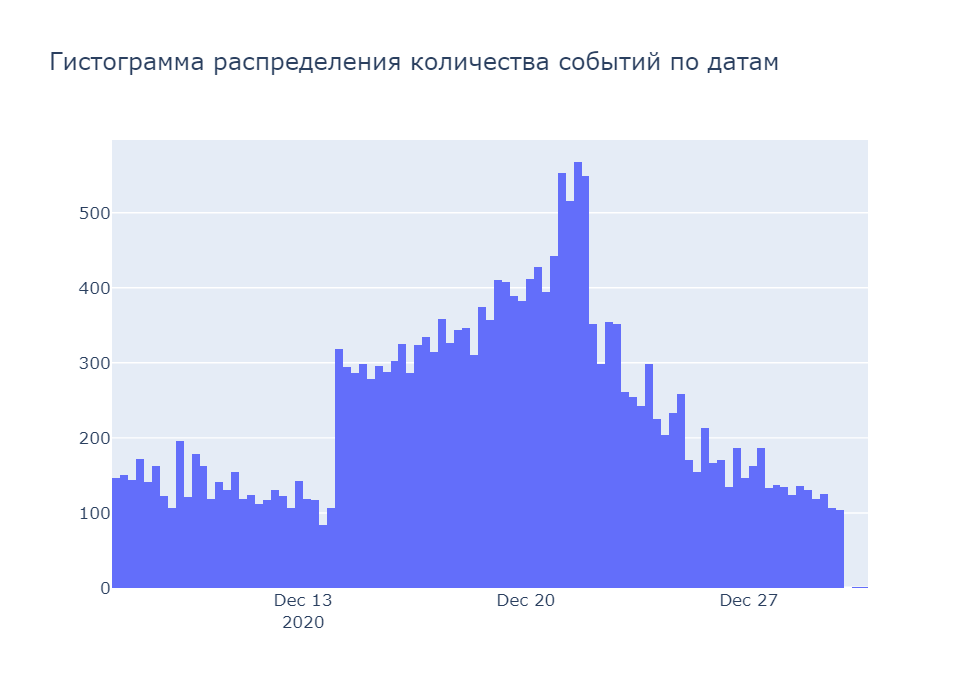

In [21]:
# выведем гистограмму распределения количества событий по датам
fig = go.Figure(data=[go.Histogram(x=events.query('user_id in @participants_eu')['event_time'], nbinsx=150)])
fig.update_layout(title="Гистограмма распределения количества событий по датам")

fig.show()

На графике заметен только один самый большой пик 21 декабря, хотя в эту дату никакх рекламных событий не происходило. В целом с 25 декабря пиков не наблюдается, поэтому скорее всего предновогодня рекламная компания значительно не повлияла на действия наших пользователей.

<a id="corr_events"></a>

### Соответствие ТЗ по событиям

In [22]:
# соединим таблицы по пользователям
events_ab = participants[['user_id', 'group']].merge(events, on='user_id', how='inner')

# посчиатем количество пользователей, совершивших событие
print('Количество пользователей, совершивших событие: {}\n'
      'Доля пользователей, совершивших событие: {:.2%}'.format(events_ab['user_id'].nunique(),
                                                           events_ab['user_id'].nunique()/participants['user_id'].nunique()))

Количество пользователей, совершивших событие: 3244
Доля пользователей, совершивших событие: 54.82%


Всего 3244 пользователей, совершившие то или иное событие, что составляет 54.82% от всех пользователей теста, т.е. чуть больше половины пользователей теста.     
Посмотрим, как распределены такие пользователи по группам. 

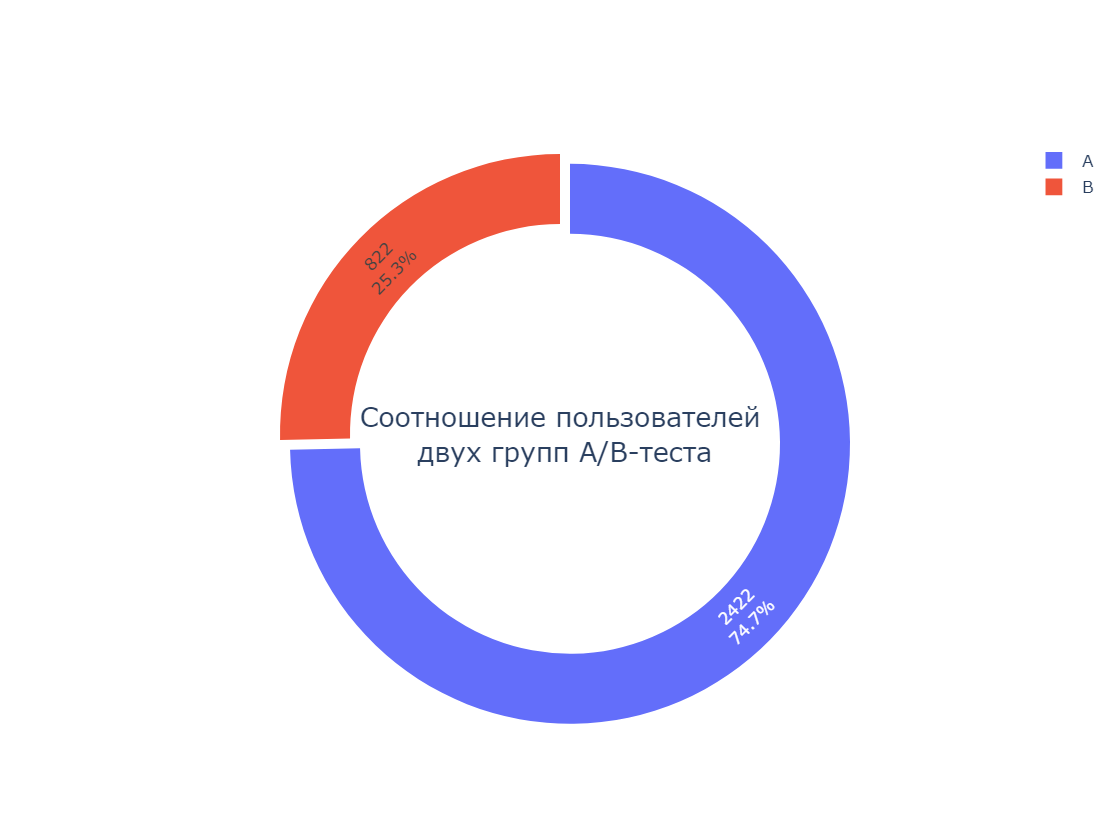

In [23]:
events_ab = participants[['user_id', 'group']].merge(events, on='user_id')
ab = events_ab.groupby(['group']).agg({'user_id': 'nunique'}).reset_index()

# выведем круговую диаграмму
fig = go.Figure(data=[go.Pie(labels=['А', 'В'], 
                             values=ab['user_id'],
                             pull=[0.05, 0],
                             hole=0.75)])
fig.update_layout(width=800,
                  height=600,
                  annotations=[dict(text='Соотношение пользователей<br> двух групп А/В-теста', 
                                   x=0.5, 
                                   y=0.5, 
                                   font_size=19, 
                                   showarrow=False)])
fig.update_traces(textinfo='percent + value')
fig.show()

Итак, в тестовой группе В совершили события лишь 25,3% пользователей и 74,7% пользователей контрольной группы А от всех пользователей теста. Группы распределены неравномерно. Количество пользователей в группе А в 3 раза превышает количество пользователей группы В.

Согласно ТЗ ожидаемый эффект должен произойти за 14 дней с момента регистрации.    
Поэтому рассчитаем лайфтайм для каждого пользователя и оставим события, совершенные до 14 дня с момента регистрации пользователя.

In [24]:
# соединим таблицы по пользователям
users_ab = events_ab.merge(users, on='user_id', how='left')

# рассчитываем лайфтайм пользователя и сохраняем события до 14 дня с момента регистрации
users_ab['liftime'] = (users_ab['event_dt'] - users_ab['first_date']).dt.days
ab_test = users_ab.query('liftime <= 14')

# две таблица по группам теста
a_test = ab_test.query('group == "A"')
b_test = ab_test.query('group == "B"')

ab_test.head()

,user_id,group,event_dt,event_name,details,event_time,first_date,region,device,liftime
0,D1ABA3E2887B6A73,A,2020-12-07,purchase,99.99,2020-12-07 14:43:27,2020-12-07,EU,PC,0
2,D1ABA3E2887B6A73,A,2020-12-07,product_cart,NaN,2020-12-07 14:43:29,2020-12-07,EU,PC,0
4,D1ABA3E2887B6A73,A,2020-12-07,product_page,NaN,2020-12-07 14:43:27,2020-12-07,EU,PC,0
6,D1ABA3E2887B6A73,A,2020-12-07,login,NaN,2020-12-07 14:43:27,2020-12-07,EU,PC,0
8,A7A3664BD6242119,A,2020-12-20,product_page,NaN,2020-12-20 15:46:06,2020-12-20,EU,iPhone,0


С данными выборками мы и будем работать в дальше.

**Вывод по разделу:**

**Техническое задание**  

* Название теста соответствует ТЗ: `recommender_system_test`   


* Группы соответствуют ТЗ: А (контрольная), B (новая платёжная воронка)


* Дата запуска соответствует ТЗ: 2020-12-07


* Дата остановки набора новых пользователей не соответствует ТЗ: 2020-12-21
    - ***В данных присутствовали пользователи, зарегистрировавшиеся после 21-12-2020. Таких пользователей отсеили.***


* Дата остановкине соответствует ТЗ: 2021-01-04  
    - ***В датафрейме отсутствовали данные за 4 дня - с 31 декабря по 4 января.***


* Аудитория: 15% новых пользователей из региона EU - не соответствует, факт 13%   
    - ***Доля новых пользователей из региона EU, участвовавших в тесте, составляет 13.15%, вместо ожидаемых 15%***


* Ожидаемое количество участников теста: 6000
    - ***Количество участников теста составило 5918, вместо ожидаемых 6000***


* Согласно ТЗ ожидаемый эффект должен произойти за 14 дней с момента регистрации. 
    - ***Данные подготовлены. Количество участников теста после фильтрации составило 3244*** 
 
Реальных данных по количеству пользователей составило чуть больше 50% от ожидаемых

<a id="research"></a>
## Исследовательский анализ данных

<a id="analysis_events"></a>
### Анализ событий

Посмотрим на распределения количества событий на пользователя.

In [25]:
# сгруппируем данные по группам и посчитаем количество событий и количество уникальных пользователей
event_per_user = ab_test.groupby('group').agg({'event_name': 'count', 'user_id': 'nunique'})

# посчитаем количество событий на пользователя
event_per_user['event_per_user'] = (event_per_user['event_name']/event_per_user['user_id']).round(2)

display(event_per_user)

print('Отностительная разница между группами по количеству событий на пользователя: {:.2%}'.format(
    event_per_user.loc['A','event_per_user']/event_per_user.loc['B','event_per_user'] - 1)
     )

,event_name,user_id,event_per_user
group,,,
A,16821,2422,6.95
B,4455,822,5.42


Отностительная разница между группами по количеству событий на пользователя: 28.23%


В группе А пользователи в среднем совершают около 6-7 событий, а пользователи группы В - 5 событий, что на 28% меньше группы А.  
Рассмотрим распределение событий по дням. Для этого выведем столбчатый график по сгруппированной таблице.

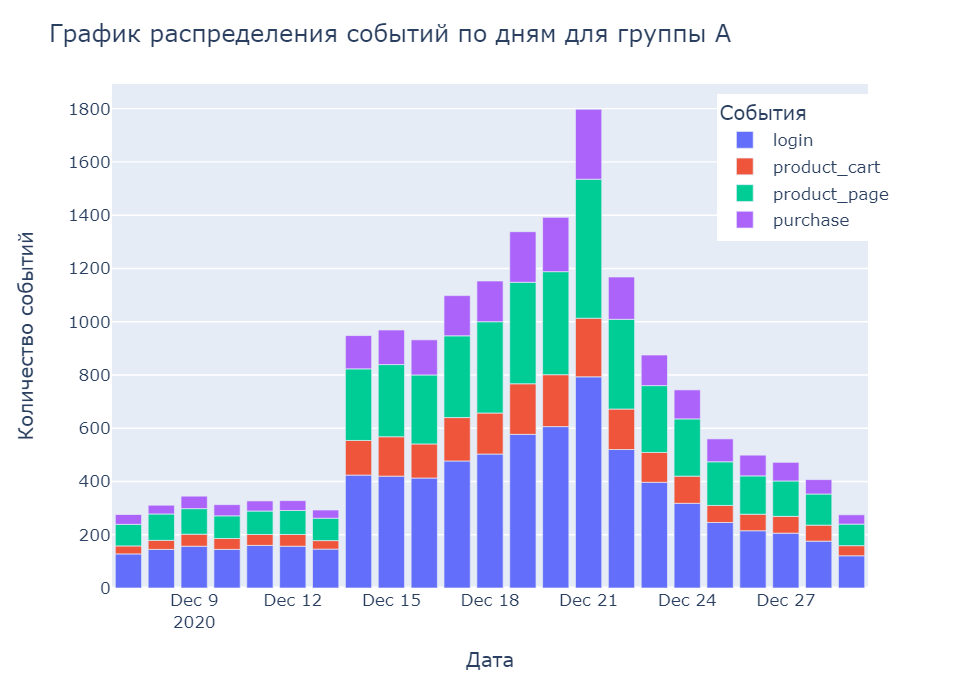

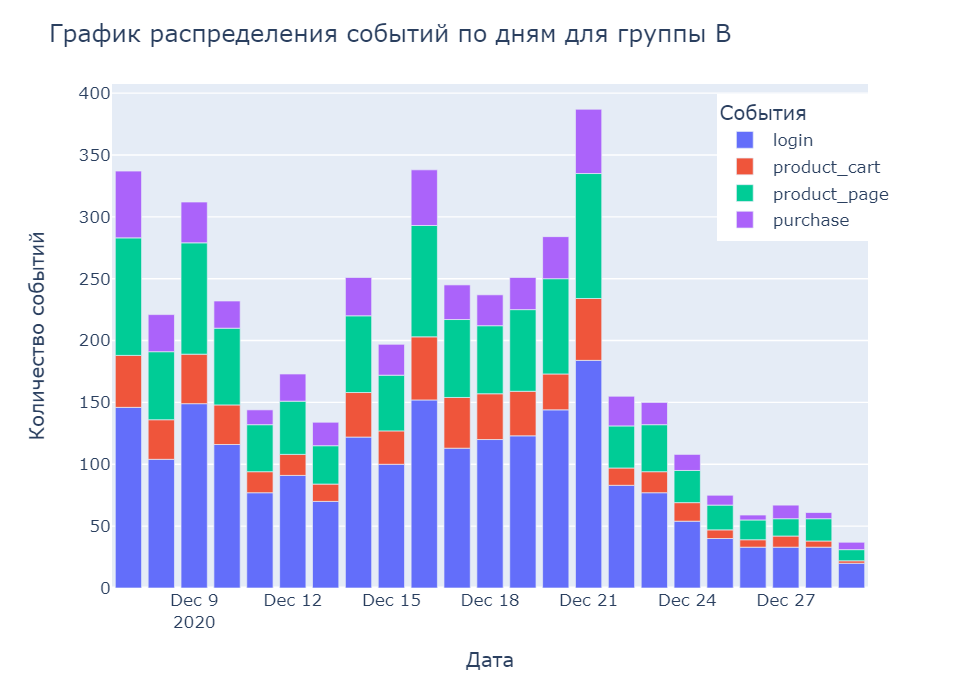

In [26]:
event_date_a = a_test.groupby(['event_dt', 'event_name']).agg({'user_id': 'count'}).reset_index()
event_date_b = b_test.groupby(['event_dt', 'event_name']).agg({'user_id': 'count'}).reset_index()

figA = px.bar(event_date_a, x='event_dt', y='user_id', color='event_name')
figA.update_layout(title_text='График распределения событий по дням для группы А',
                  xaxis_title='Дата',
                  yaxis_title='Количество событий',
                  legend=dict(x=.8,  y=.98),
                  legend_title=dict(text = 'События'))
figA.show()

figB = px.bar(event_date_b, x='event_dt', y='user_id', color='event_name')
figB.update_layout(title_text='График распределения событий по дням для группы В',
                  xaxis_title='Дата',
                  yaxis_title='Количество событий',
                  legend=dict(x=.8,  y=.98),
                  legend_title=dict(text = 'События'))
figB.show()

В группе А события распределены более равномерно, чем в группе В. В группе А наблюдается рост только 14 декабря, в то время в группе В рост количества событий происходил скачкообразно вплоть до 21 декабря, что скорее связано с размером выборки. В обеих группах можно заметить самые большие пики 21 декабря, а в группе В еще и 7, 9 и 16 декабря.   
Самое большое количество покупок в группе А наблюдается также 21 декабря, а в группе В - 7 и 21 декабря. Возможно в этот день проводились какие-то акции на сайте.

<a id="funnel"></a>

### Воронка событий

Посмотрим на изменение конверсии в воронке в выборках на разных этапах. Для этого построим последовательную таблицу событий для каждой из групп.

In [27]:
# посчитаем частоту каждого события, количество уникальных пользователей, которые совершали это событие,
# переименум столбцы и сортируем события по числу таких пользователей по убыванию для каждой группы
funnel_a = a_test.groupby('event_name').agg(
    {'event_dt': 'count',  'user_id': 'nunique'}).reset_index().rename(
    columns={'event_dt': 'count_events', 'user_id': 'count_users'}).sort_values('count_users', ascending=False)

funnel_b = b_test.groupby('event_name').agg(
    {'event_dt': 'count',  'user_id': 'nunique'}).reset_index().rename(
    columns={'event_dt': 'count_events', 'user_id': 'count_users'}).sort_values('count_users', ascending=False)

# посчитаем долю пользователей, которые хоть раз совершали событие
funnel_a['conversion'] = round(funnel_a['count_users']/a_test['user_id'].nunique() * 100, 1)
funnel_b['conversion'] = round(funnel_b['count_users']/b_test['user_id'].nunique() * 100, 1)

# посчситаем долю пользователей, которые проходят на следующий шаг воронки от числа пользователей на предыдущем
funnel_a['conversion_previous'] = round(funnel_a['count_users']/funnel_a['count_users'].shift(periods=1).fillna(2422) * 100, 1)
funnel_b['conversion_previous'] = round(funnel_b['count_users']/funnel_b['count_users'].shift(periods=1).fillna(821) * 100, 1)
funnel_a, funnel_b = funnel_a.reindex([0,2,1,3]), funnel_b.reindex([0,2,1,3])

display(funnel_a, funnel_b)

,event_name,count_events,count_users,conversion,conversion_previous
0,login,7450,2422,100.0,100.0
2,product_page,4804,1571,64.9,64.9
1,product_cart,2248,728,30.1,94.2
3,purchase,2319,773,31.9,49.2


,event_name,count_events,count_users,conversion,conversion_previous
0,login,2184,821,99.9,100.0
2,product_page,1148,459,55.8,55.9
1,product_cart,576,225,27.4,99.6
3,purchase,547,226,27.5,49.2


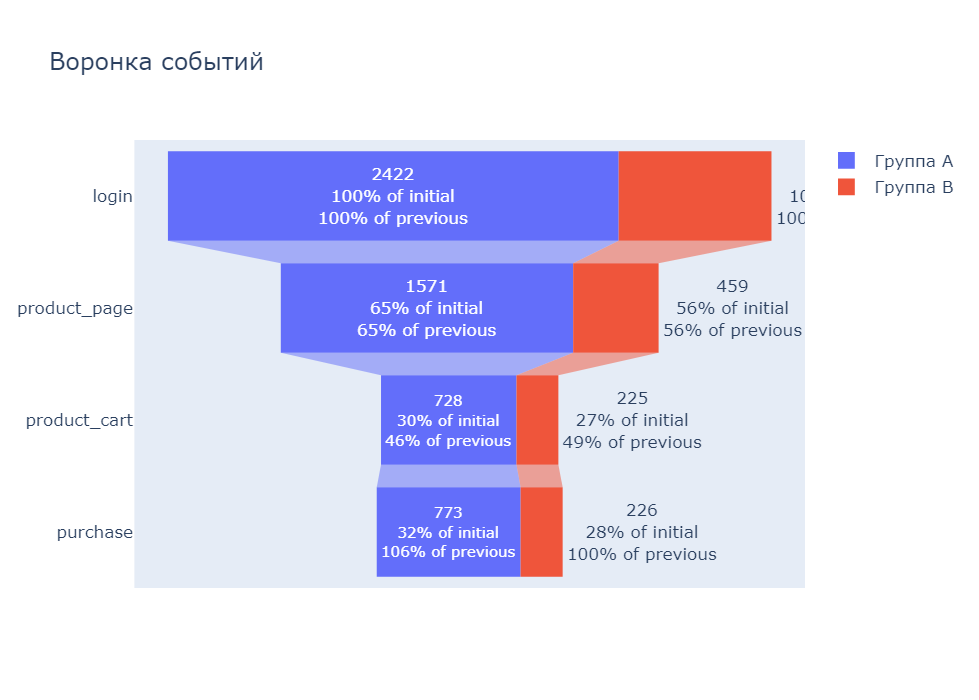

In [28]:
fig = go.Figure()
# по воронке событий визуализируем количество и долю пользователей группы А, которые проходят на следующий шаг воронки
fig.add_trace(go.Funnel(
    y=funnel_a['event_name'], x=funnel_a['count_users'], textinfo = 'value+percent previous+percent initial', name='Группа А'))
fig.add_trace(go.Funnel(
    y=funnel_b['event_name'], x=funnel_b['count_users'], textinfo = 'value+percent previous+percent initial', name='Группа B'))
fig.update_layout(title="Воронка событий")

fig.show()

Итак, самым часто встречаемым событием является `login` - авторизация/вход, после чего `product_page` - просмотр страницы предложений/товара, далее у групп идет расхождение - у группы В `product_cart` - открытие страницы корзины, следом за ней `purchase` - покупка, но у группы А наоборот - чаще идет сразу `purchase` - покупка и на самом последнем месте `product_cart` - открытие страницы корзины.  

Можно заметить, что порядок событий по количеству уникальных пользователей и их доле абсолютно одинаковый у двух групп.
Так, до этапа открытия страницы корзины доходят почти 27-30% пользователей в обоих группах, а до покупки немного даже больше - около 28-32% пользователей. Скорее всего открытие корзины не обязательно и есть возможность купить товар в один клик, поэтому переход к покупке может быть с большей конверсией.

В общем конверсия группы А, не смотря на размер выборок, лучше конверсии группы В, поэтому ожидаемый эффект увеличения конверсии пользователей не менее, чем на 10%, не оправдался.

**Вывод по разделу**

* В группе А пользователи в среднем совершают около 6-7 событий, а пользователи группы В - 5 событий, что на 28% меньше группы А.
* В группе А события распределены более равномерно, чем в группе В. В обеих группах можно заметить самые большие пики 21 декабря, а в группе В еще и 7, 9 и 16 декабря. Самое большое количество покупок в группе А наблюдается также 21 декабря, а в группе В - 7 и 21 декабря. Возможно в этот день проводились какие-то акции на сайте.
* Так, до этапа открытия страницы корзины доходят почти 27-30% пользователей в обоих группах, а до покупки немного даже больше - около 28-32% пользователей. Скорее всего открытие корзины не обязательно и есть возможность купить товар в один клик, поэтому переход к покупке может быть с большей конверсией. Конверсия группы А, не смотря на размер выборок, лучше конверсии группы В, поэтому ожидаемый эффект увеличения конверсии пользователей не менее, чем на 10%, не оправдался.


<a id="stats"></a>

## Оценка результатов A/B-тестирования

Проанализируем А/В-тест с использованием функции `z_test()` и дополнительного цикла.

Сформулируем гипотезы:

* Гипотеза H0: Различия в долях отсутствуют
* Гипотеза H1: Различия в долях присутствуют

Для начала создадим сводную таблицу количества пользователей каждой группы на каждом событии, а также добавим в таблицу всего пользователей, всего пользователей на каждом событии.

In [29]:
# создадим сводную таблицу количества пользователей каждой группы на каждом событии
# сортируем по убыванию общего числа пользователей и сбросим индексы
pivot_ab = ab_test.pivot_table(
    index='event_name', columns='group', values='user_id', aggfunc='nunique', margins=True
).sort_values('All', ascending=False).reset_index()

# переименуем столбцы
pivot_ab.columns = ['event_name', 'A', 'B', 'All']

pivot_ab = pivot_ab.reindex([0,1,2,4,3]).reset_index(drop=True)
pivot_ab

,event_name,A,B,All
0,All,2422,822,3244
1,login,2422,821,3243
2,product_page,1571,459,2030
3,product_cart,728,225,953
4,purchase,773,226,999


Далее создадим функцию для проверки гипотезы о равенстве долей, которая принимает на вход строку события, первую группу и вторую группу эксперимента, а на выход выдает результат проверки гипотез:

In [30]:
def z_test(event, group1, group2):
    
    # критический уровень статистической значимости
    alpha = .05 
    # поправка Бинферрони
    alpha_binferroni = alpha/4
    
    successes1 = pivot_ab.loc[event, group1]
    successes2 = pivot_ab.loc[event, group2]
    trials1 = pivot_ab.loc[0, group1]
    trials2 = pivot_ab.loc[0, group2]
    
    # пропорция успехов в первой группе:
    p1 = successes1/trials1
    
    # пропорция успехов во второй группе:
    p2 = successes2/trials2
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if p_value < alpha_binferroni:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

 Осталось написанной функией пройтись по событиям с помощью цикла и вывести результат A/B-тестирования.

In [31]:
# создадим список уникаальных событий в правильной последовательности
event_name = ['login', 'product_page', 'product_cart', 'purchase']

print(f'СРАВНЕНИЕ ГРУПП - A и B:')
print()
for event, name in enumerate(event_name, start=1):
    print(f'Для события {name}:')
    z_test(event, 'A', 'B')
    print()
  

СРАВНЕНИЕ ГРУПП - A и B:

Для события login:
p-значение:  0.08601687380547407
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события product_page:
p-значение:  3.8415005565450855e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница

Для события product_cart:
p-значение:  0.14412076974264498
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события purchase:
p-значение:  0.01764968717521609
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод**

Таким образом, сравнение групп по событиям показало статистические значимые различия между группами есть только на этапе просмотров страницы предложений/товара `product_page`, что дает оснований считать доли разными, следовательно, отвергаем нулевую гипотезу, а при входе, просмотре корзины и покупке статистически значимых различий нет.

Мы провели 4 проверки в А/В-тесте. При множественном сравнении, чтобы снизить вероятность ложнопозитивного результата (ошибки первого рода), уменьшая уровень значимости, мы использовали поправку Бонферрони. Тем самым, мы снизили уровень статистической значимости до 0,0125.

Однако исходя из выше проведенного исследования можно сказать о том, что статистически значимые различия говорят лишь о понижении конверсии группы В. Исходя из этого, можно сделать вывод, что тестовые изменения показали противоположный результат.

<a id="rec"></a>

## Общий вывод

<div class="alert alert-info">   

------------------------------------------------------------------------------------------------------------------------------
    
**1. Была изучена общая информация о датафреймах.**
    
Файл, содержащий информацию о участниках тестов, имеет всего 18268 записи и 3 столбца.
Файл, содержащий информацию о маркетинговых событиях на 2020 год, имеет всего 14 записей и 4 столбца. 
Файл, содержащий информацию о всех пользователях, зарегистрировавшихся в интернет-магазине в период с 7 по 21 декабря 2020 года, имеет всего 61733 записи и 4 столбца.
Файл, содержащий информацию о событиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года, имеет всего 440317 записей и 4 столбца. 

-----------------------------------------------------------------------------------------------------------------------------  
    
**2. В разделе предобратоки данных:**


* изменили типы данных в `start_dt`, `finish_dt`, `first_date` и `event_dt`
* Пропуски обнаружились во всех событиях, кроме покупки. Не стали ничего менять
* Строк-дубликатов не обнаружили
    
-------------------------------------------------------------------------------------------------------------------------------
    
**3. Оценка корректности проведения теста:**

**Техническое задание**  

* Название теста соответствует ТЗ: `recommender_system_test`   


* Группы соответствуют ТЗ: А (контрольная), B (новая платёжная воронка)


* Дата запуска соответствует ТЗ: 2020-12-07


* Дата остановки набора новых пользователей не соответствует ТЗ: 2020-12-21
    - ***В данных присутствовали пользователи, зарегистрировавшиеся после 21-12-2020. Таких пользователей отсеили.***


* Дата остановки не соответствует ТЗ: 2021-01-04
    - ***В датафрейме отсутствовали данные за 4 дня - с 31 декабря по 4 января.***


* Аудитория: 15% новых пользователей из региона EU - не соответствует, факт 13%   
    - ***Доля новых пользователей из региона EU, участвовавших в тесте, составляет 13.15%, вместо ожидаемых 15%***


* Ожидаемое количество участников теста: 6000
    - ***Количество участников теста составило 5918, вместо ожидаемых 6000***


*  Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`. 
    ***Количество участников теста после фильтрации составило 3244. Ожидаемый эффект увеличения конверсии пользователей не менее, чем на 10%, не оправдался*** 
 
    
Всего 3244 пользователей, совершившие то или иное событие, что составляет 54.82% от всех пользователей теста, т.е. чуть больше половины пользователей теста.   
В тестовой группе В совершили события лишь 25,3% пользователей и 74,7% пользователей контрольной группы А от всех пользователей теста. Группы распределены неравномерно. 
Количество пользователей в группе А в 3 раза превышает количество пользователей группы В.
    
Реальных данных по количеству пользователей составило чуть больше 50% от ожидаемых.

-------------------------------------------------------------------------------------------------------------------------------
    
**4. Исследовательский анализа данных**  
    
* В группе А пользователи в среднем совершают около 6-7 событий, а пользователи группы В - 5 событий, что на 28% меньше группы А.
    
* В группе А события распределены более равномерно, чем в группе В. 
    
* Самым часто встречаемым событием является `login` - авторизация/вход, после чего `product_page` - просмотр страницы предложений/товара, далее у групп идет расхождение - у группы В `product_cart` - открытие страницы корзины, следом за ней `purchase` - покупка, но у группы А наоборот - чаще идет сразу `purchase` - покупка и на самом последнем месте `product_cart` - открытие страницы корзины.  

Так, до этапа открытия страницы корзины доходят почти 27-30% пользователей в обоих группах, а до покупки немного даже больше - около 28-32% пользователей. Скорее всего открытие корзины не обязательно и есть возможность купить товар в один клик, поэтому переход к покупке может быть с большей конверсией.

Таким образом, конверсия группы А, не смотря на размер выборок, лучше конверсии группы В, поэтому ожидаемый эффект увеличения конверсии пользователей не менее, чем на 10%, не оправдался.
 
---------------------------------------------------------------------------------------------------------------------------    

**5. Статистический аналих данных**
    
* Сформулируем гипотезы:

    * Гипотеза H0: Различия в долях отсутствуют
    * Гипотеза H1: Различия в долях присутствуют

    Вывод: 
    - Различия по долям между группами участников статистически значимы только на этапах просмотров страницы предложений/товара `product_page` и покупок `purchase`, что дает оснований считать доли разными, следовательно, отвергаем нулевую гипотезу, а при просмотре корзины статистически значимых различий нет.;
    - Однако исходя конверсии можно сказать о том, что статистически значимые различия говорят лишь о понижении конверсии группы В. Исходя из этого, можно сделать вывод, что тестовые изменения показали противоположный результат.    
---------------------------------------------------------------------------------------------------------------------------    
    
**Вывод и рекомендации:**

Сложно назвать проведение данного теста корректным решением.   
Доля новых пользователей из региона EU, участвовавших в тесте, составляет 13.15%, вместо ожидаемых 15%   
Количество участников теста составило 5918, вместо ожидаемых 6000.      
Всего 3244 пользователей, совершившие то или иное событие, что составляет 54.82% от всех пользователей теста.        
Реальных данных по количеству пользователей составило чуть больше 50% от ожидаемых.         
Ожидаемый эффект увеличения конверсии пользователей не менее, чем на 10%, не оправдался и дал обратный эффект.       
    
Данных не достаточно, чтобы делать какой-то однозначный вывод. Также стоит учитывать, что в данных присутствуют праздничные дни, которые из-за ажиотажа могут исказить результаты исследования. Более того, на период проведения тестирования выпали маркетинговые рекламные компании, что тоже могло исказить результаты.
Также стоит отметить, что данные по группам были распределены неравномерно, а в обоих тестах находились пересечения по пользователям. 
    
Таким образом, ожидаемого эффекта рекомендательная система не достигла.